# Imports

In [2]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
# Above is a special style template for matplotlib, highly useful for visualizing time series data
%matplotlib inline
from pylab import rcParams
from plotly import tools
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
import statsmodels.api as sm
from numpy.random import normal, seed
import plotly.express as px
from scipy.stats import norm
import scipy.stats as st
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import math
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout

# Reading Data

In [3]:
train_df= pd.read_csv("/content/drive/MyDrive/training_data.csv")
train = train_df.copy()
test_df = pd.read_csv("/content/drive/MyDrive/prediction_template.csv")
test = test_df.copy()
train_df.head()


,Date,Tenor,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9
0,1/5/2017,2M,0.468214,0.419251,0.376260,0.338158,0.304372,0.274823,0.250066,0.231535,...,0.220933,0.228418,0.240437,0.254316,0.268613,0.282659,0.296172,0.309045,0.321260,0.332831
1,1/5/2017,3M,0.458471,0.412710,0.372717,0.337489,0.306511,0.279714,0.257540,0.241007,...,0.229423,0.233839,0.242411,0.253100,0.264611,0.276244,0.287647,0.298654,0.309196,0.319254
2,1/5/2017,6M,0.410305,0.374189,0.343045,0.316070,0.292842,0.273231,0.257346,0.245440,...,0.234116,0.234078,0.236765,0.241295,0.246945,0.253200,0.259726,0.266312,0.272831,0.279207
3,1/5/2017,9M,0.385267,0.354580,0.328360,0.305878,0.286712,0.270643,0.257590,0.247529,...,0.236030,0.234085,0.234121,0.235658,0.238264,0.241586,0.245360,0.249397,0.253564,0.257773
4,1/5/2017,1Y,0.358986,0.333608,0.312126,0.293870,0.278408,0.265457,0.254819,0.246339,...,0.235185,0.232109,0.230384,0.229760,0.230003,0.230908,0.232303,0.234052,0.236049,0.238213


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13642 entries, 0 to 13641
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    13642 non-null  object 
 1   Tenor   13642 non-null  object 
 2   0.1     13642 non-null  float64
 3   0.2     13642 non-null  float64
 4   0.3     13642 non-null  float64
 5   0.4     13642 non-null  float64
 6   0.5     13642 non-null  float64
 7   0.6     13642 non-null  float64
 8   0.7     13642 non-null  float64
 9   0.8     13642 non-null  float64
 10  0.9     13642 non-null  float64
 11  1       13642 non-null  float64
 12  1.1     13642 non-null  float64
 13  1.2     13642 non-null  float64
 14  1.3     13642 non-null  float64
 15  1.4     13642 non-null  float64
 16  1.5     13642 non-null  float64
 17  1.6     13642 non-null  float64
 18  1.7     13642 non-null  float64
 19  1.8     13642 non-null  float64
 20  1.9     13642 non-null  float64
dtypes: float64(19), object(2)
memory us

# Data Preprocessing
* Change Date to python's datetime object.
* Change Tenure Scale to days.
* Add Date to Index for time series Analysis.

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13642 entries, 0 to 13641
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    13642 non-null  object 
 1   Tenor   13642 non-null  object 
 2   0.1     13642 non-null  float64
 3   0.2     13642 non-null  float64
 4   0.3     13642 non-null  float64
 5   0.4     13642 non-null  float64
 6   0.5     13642 non-null  float64
 7   0.6     13642 non-null  float64
 8   0.7     13642 non-null  float64
 9   0.8     13642 non-null  float64
 10  0.9     13642 non-null  float64
 11  1       13642 non-null  float64
 12  1.1     13642 non-null  float64
 13  1.2     13642 non-null  float64
 14  1.3     13642 non-null  float64
 15  1.4     13642 non-null  float64
 16  1.5     13642 non-null  float64
 17  1.6     13642 non-null  float64
 18  1.7     13642 non-null  float64
 19  1.8     13642 non-null  float64
 20  1.9     13642 non-null  float64
dtypes: float64(19), object(2)
memory us

In [6]:
import re

train_df['Date'] = pd.to_datetime(train_df['Date'] , format = '%m/%d/%Y')

# using datetime to calculate time exact difference
train_df['End_Tenure_Date'] = train_df['Date'] + train_df["Tenor"].apply(lambda x: pd.DateOffset(years=int(''.join(x.split('Y')[:-1]))) if (x[-1]=='Y') else pd.DateOffset(months=int(''.join(x.split('M')[:-1]))))
train_df['Tenure'] = (train_df['End_Tenure_Date'] - train_df['Date']).dt.days

train_df.drop(['Tenor','End_Tenure_Date'],axis=1,inplace=True)


train_df.head()

,Date,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,Tenure
0,2017-01-05,0.468214,0.419251,0.376260,0.338158,0.304372,0.274823,0.250066,0.231535,0.221404,...,0.228418,0.240437,0.254316,0.268613,0.282659,0.296172,0.309045,0.321260,0.332831,59
1,2017-01-05,0.458471,0.412710,0.372717,0.337489,0.306511,0.279714,0.257540,0.241007,0.231434,...,0.233839,0.242411,0.253100,0.264611,0.276244,0.287647,0.298654,0.309196,0.319254,90
2,2017-01-05,0.410305,0.374189,0.343045,0.316070,0.292842,0.273231,0.257346,0.245440,0.237726,...,0.234078,0.236765,0.241295,0.246945,0.253200,0.259726,0.266312,0.272831,0.279207,181
3,2017-01-05,0.385267,0.354580,0.328360,0.305878,0.286712,0.270643,0.257590,0.247529,0.240401,...,0.234085,0.234121,0.235658,0.238264,0.241586,0.245360,0.249397,0.253564,0.257773,273
4,2017-01-05,0.358986,0.333608,0.312126,0.293870,0.278408,0.265457,0.254819,0.246339,0.239855,...,0.232109,0.230384,0.229760,0.230003,0.230908,0.232303,0.234052,0.236049,0.238213,365


In [ ]:
train_df['Date']

0       2017-01-05
1       2017-01-05
2       2017-01-05
3       2017-01-05
4       2017-01-05
           ...    
13637   2019-10-14
13638   2019-10-14
13639   2019-10-14
13640   2019-10-14
13641   2019-10-14
Name: Date, Length: 13642, dtype: datetime64[ns]

# Data Analysis



In [11]:
styles = [
    dict(selector="tr",
                props=[("background", "#fcf0f0")]),
    dict(selector="th", props=[("color", "#fff"),
                               ("border", "1px solid #8081d1"),
                               ("padding", "12px 35px"),
                               ("border-collapse", "collapse"),
                               ("background", "#00cccc"),
                               ("text-transform", "uppercase"),
                               ("font-size", "18px")
                               ]),
    dict(selector="td", props=[("color", "#999"),
                               ("border", "1px solid #8081d1"),
                               ("padding", "12px 35px"),
                               ("border-collapse", "collapse"),
                               ("font-size", "15px")
                               ]),
    dict(selector="table", props=[
                                    ("font-family" , 'Arial'),
                                    ("margin" , "25px auto"),
                                    ("border-collapse" , "collapse"),
                                    ("border" , "1px solid #8081d1"),
                                    ("border-bottom" , "2px solid #00cccc"),                                    
                                      ]),
    dict(selector="caption", props=[("caption-side", "bottom")])
]

In [12]:
desc = train_df.describe()
# desc.style.background_gradient()
desc.style.set_table_styles(styles).set_caption("(Made in Pandas)").highlight_max().highlight_null(null_color='red').to_excel('styled.xlsx', engine='openpyxl')
# df.style.background_gradient()


In [13]:
min_strike = np.min(desc.transpose()['min'])

max_strike = np.max(desc.drop('Tenure',axis=1).transpose()['max'])

print('Max Strike')
print(train_df[train_df['0.1']>=0.6872][['Tenure','0.1','Date']])
print('\n\nMin Strike')
print(train_df[train_df['1.5']<=0.105756][['Tenure','1.5','Date']])

Max Strike
       Tenure       0.1       Date
12844      61  0.687277 2019-08-16


Min Strike
      Tenure       1.5       Date
5224   14610  0.105756 2018-01-24


* Strike prices are close to each other.
* No missing imputation required.
* Highest strike was ~0.6872 for the tenure of 60 days in 0.1 feature.
* Least strike price was ~0.1057 for the tenure of 14610 days in 1.5 feature.

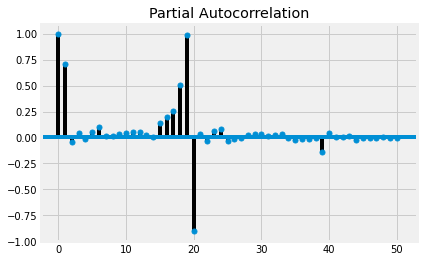

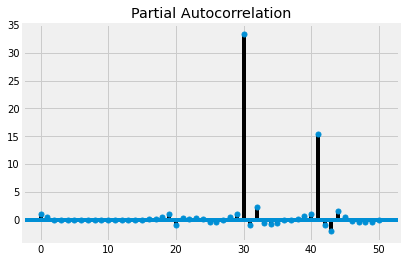

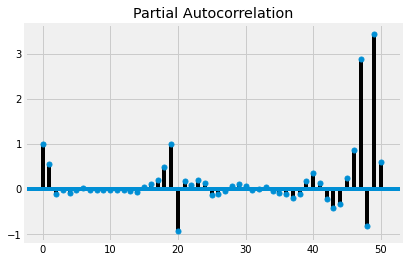

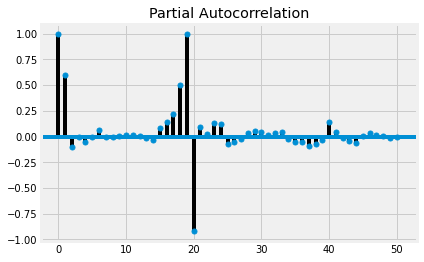

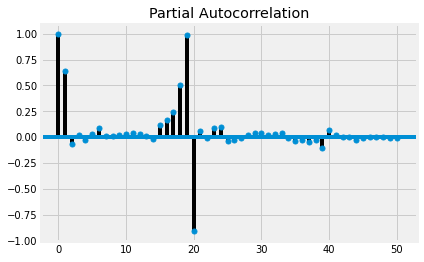

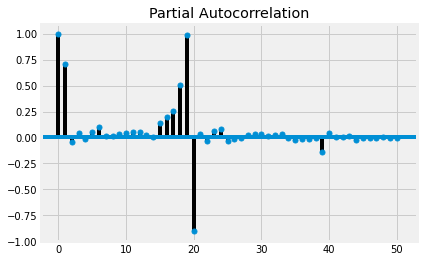

In [ ]:
# Partial Autocorrelation of humidity of San Diego
plot_pacf(train_df["0.2"],lags=50)
plot_pacf(train_df["0.3"],lags=50)
plot_pacf(train_df["0.4"],lags=50)
plot_pacf(train_df["0.5"],lags=50)
plot_pacf(train_df["0.6"],lags=50)

* There Exists Patial Auto Correlation (i.e., relation of data with its past lags or  contribution of a change in that particular lag while holding others constant) within IVs

In [18]:
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
def create_corr_plot(series, plot_pacf=False):
    corr_array = pacf(series.dropna(), alpha=0.05,nlags=10) if plot_pacf else acf(series.dropna(), alpha=0.05,nlags=40)
    lower_y = corr_array[1][:,0] - corr_array[0]
    upper_y = corr_array[1][:,1] - corr_array[0]

    fig = go.Figure()
    [fig.add_scatter(x=(x,x), y=(0,corr_array[0][x]), mode='lines',line_color='#3f3f3f') 
     for x in range(len(corr_array[0]))]
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=corr_array[0], mode='markers', marker_color='#1f77b4',
                   marker_size=12)
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=upper_y, mode='lines', line_color='rgba(255,255,255,0)')
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=lower_y, mode='lines',fillcolor='rgba(32, 146, 230,0.3)',
            fill='tonexty', line_color='rgba(255,255,255,0)')
    fig.update_traces(showlegend=False)
    fig.update_xaxes(range=[-1,42])
    fig.update_yaxes(zerolinecolor='#000000')
    
    title=f'Partial Autocorrelation (PACF) FOr {title}' if plot_pacf else f'Autocorrelation (ACF) for {title}'
    fig.update_layout(title=title)
    fig.show(renderer='colab')


In [ ]:
create_corr_plot(avg['0.2'],plot_pacf=True)

In [ ]:
create_corr_plot(avg['0.1'],plot_pacf=False)

In [ ]:
corr = train_df.corr()
corr.style.background_gradient(cmap='coolwarm')


* There exists high correlation between the strike prices.

## OHLC Chart
An OHLC chart is a type of price chart that shows the open, high, low and close price of a certain time period.

Here, the chart shows Volatility instead of price(On Y-axis) for different strike prices for the given duration.

In [ ]:
groups = train_df.groupby(['Date'])

In [ ]:

opens = groups.agg(lambda x: x.iloc[0])
# opens.columns = train_df.columns

closes = groups.agg(lambda x: x.iloc[-1])
# closes.columns = train_df.columns

highs = groups.agg(lambda x: np.max(x))
# highs.columns = train_df.columns

lows = groups.agg(lambda x: np.min(x))
# lows.columns = train_df.columns

In [ ]:
fig = go.Figure()
columns = ['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9',
       '1', '1.1', '1.2', '1.3', '1.4', '1.5', '1.6', '1.7', '1.8', '1.9']
for i in columns:
    fig.add_trace(
        go.Ohlc(x=opens.index,
                open=opens[i],
                high=highs[i],
                close=closes[i],
                low=lows[i],
                )
    )

fig.update_layout(
    title='OHLC For diff strike prices(moneyness)',
    yaxis_title='volatility',
    xaxis_title='Time Period'
)
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show(renderer="colab")


## Trend,Seasonality, Noise
Trend - Consistent upwards or downwards slope of a time series

Seasonality - Clear periodic pattern of a time series

Noise - Outliers or missing values

In [ ]:
avg = groups.agg('mean')
# avg.columns = train_df.columns
avg.head()

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,Tenure
Date,,,,,,,,,,,,,,,,,,,,
2017-01-05,0.337299,0.312359,0.290630,0.271536,0.254706,0.239954,0.227252,0.216697,0.208431,0.202474,0.198569,0.196279,0.195203,0.195043,0.195583,0.196655,0.198130,0.199904,0.201894,3587.842105
2017-01-06,0.335328,0.310354,0.288584,0.269443,0.252562,0.237753,0.224996,0.214396,0.206115,0.200195,0.196374,0.194192,0.193230,0.193184,0.193833,0.195009,0.196581,0.198446,0.200519,3587.842105
2017-01-09,0.336420,0.311710,0.290160,0.271215,0.254518,0.239892,0.227316,0.216893,0.208751,0.202901,0.199084,0.196869,0.195859,0.195755,0.196342,0.197453,0.198959,0.200756,0.202763,3587.842105
2017-01-10,0.336569,0.311863,0.290320,0.271383,0.254699,0.240088,0.227531,0.217129,0.209001,0.203146,0.199310,0.197071,0.196039,0.195917,0.196488,0.197586,0.199081,0.200868,0.202866,3587.842105
2017-01-11,0.336351,0.311667,0.290144,0.271225,0.254555,0.239956,0.227409,0.217010,0.208880,0.203020,0.199177,0.196930,0.195888,0.195757,0.196319,0.197409,0.198896,0.200676,0.202667,3587.842105


In [ ]:

import plotly.express as px


columns = ['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9',
       '1', '1.1', '1.2', '1.3', '1.4', '1.5', '1.6', '1.7', '1.8', '1.9']
fig = go.Figure()
for i in columns:
   fig.add_trace(go.Scatter(x=avg.index, y=avg[i]))



fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.update_layout(
    title='Avg volatility For diff strike prices(moneyness)',
    yaxis_title='volatility',
    xaxis_title='Time Period'
)
fig.show(renderer='colab')


In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 10,10
decomposed_volat_volume = sm.tsa.seasonal_decompose(train_df["0.1"],freq=60) # The frequncy is annual
figure = decomposed_volat_volume.plot()

plt.show()

#### * No seasonality change in stock prices.
#### * No constant change in trend.
#### * uniformity(mostly) in Residuals shows non existence of outliers and missing data

# Black Scholes Model
The implied volatility was earlier calculated with Black Scholes Model.
The inputs of this model are:
 * volatility
 * price of the underlying asset
 * the strike price of the option
 * time until expiration of the option
 * risk-free interest rate

** Assumptions**
 * No dividends are paid out during the life of the option.
 * Markets are random (i.e., market movements cannot be predicted).
 * There are no transaction costs in buying the option.
 * The risk-free rate and volatility of the underlying asset are known and constant.
 * ***futures contracts, will have a lognormal distribution of prices following a random walk with constant drift and volatility***
 * The option is European and can only be exercised at expiration.


An augmented ***Dickey–Fuller test (ADF)*** tests the null hypothesis that a unit root is present in a time series sample and data is not stationary.

* Stationary series

Has a constant mean, variance and covariance,or simply that the data will follow the same pattern(trend) as in past.

In [ ]:
from statsmodels.tsa.stattools import adfuller
for i in columns:
    adf = adfuller(train_df[i])
    print("p-value of {}: {}".format(i,float(adf[1])))
    

* By ADF test , the p-value for every strike price is greater than 0.05, and therfore null hypothesis is rejected that this is stationary series.



In [ ]:
import plotly.express as px
fig = px.histogram(train_df, x="0.1",  histfunc='avg')
fig.show(renderer='colab')

In [ ]:
for i in columns:
    print(f"Skewness: {st.skew(train_df[i],bias=False)} ; Kurtosis: {st.kurtosis(train_df[i],bias=False)}")

* There exists skewness and kurtosis in the distributino of IV, hence failure to cooperate 5th assumption.

# Modelling












## Random Forest


> Rf can be used for predicting multiple outcomes.


> RF's Accuracy of Random forest is generally very high.


> RF can be used to predict multiple features.


> high correlation or VIF Score doesnot impact accuracy of RF.


> Data transformation or scaling can be avoided when using RF resulting in no loss of information.

#### Preprocessing
* split date into date,month, year.
* change tenure to date scale.

In [ ]:
train['Date'].value_counts()

1/5/2017      19
11/27/2018    19
10/30/2018    19
10/31/2018    19
11/1/2018     19
              ..
12/8/2017     19
12/11/2017    19
12/12/2017    19
12/13/2017    19
10/14/2019    19
Name: Date, Length: 718, dtype: int64

In [ ]:
train['date'] = pd.to_datetime(train['Date'] , format = '%m/%d/%Y')

# using datetime to calculate time exact difference
train['End_Tenure_Date'] = train['date'] + train["Tenor"].apply(lambda x: pd.DateOffset(years=int(''.join(x.split('Y')[:-1]))) if (x[-1]=='Y') else pd.DateOffset(months=int(''.join(x.split('M')[:-1]))))
train['Tenure'] = (train['End_Tenure_Date'] - train['date']).dt.days

train.drop(['Tenor','End_Tenure_Date','date'],axis=1,inplace=True)

In [ ]:

train["date"] = train["Date"].apply(lambda x:int(x.split("/")[0]))


train["month"] = train["Date"].apply(lambda x:int(x.split("/")[1]))


train["year"] = train["Date"].apply(lambda x:int(x.split("/")[2]))

train.drop('Date',axis=1,inplace=True)

In [ ]:
train.head()

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,...,1.4,1.5,1.6,1.7,1.8,1.9,Tenure,date,month,year
0,0.468214,0.419251,0.376260,0.338158,0.304372,0.274823,0.250066,0.231535,0.221404,0.220933,...,0.268613,0.282659,0.296172,0.309045,0.321260,0.332831,59,1,5,2017
1,0.458471,0.412710,0.372717,0.337489,0.306511,0.279714,0.257540,0.241007,0.231434,0.229423,...,0.264611,0.276244,0.287647,0.298654,0.309196,0.319254,90,1,5,2017
2,0.410305,0.374189,0.343045,0.316070,0.292842,0.273231,0.257346,0.245440,0.237726,0.234116,...,0.246945,0.253200,0.259726,0.266312,0.272831,0.279207,181,1,5,2017
3,0.385267,0.354580,0.328360,0.305878,0.286712,0.270643,0.257590,0.247529,0.240401,0.236030,...,0.238264,0.241586,0.245360,0.249397,0.253564,0.257773,273,1,5,2017
4,0.358986,0.333608,0.312126,0.293870,0.278408,0.265457,0.254819,0.246339,0.239855,0.235185,...,0.230003,0.230908,0.232303,0.234052,0.236049,0.238213,365,1,5,2017


#### Training

In [ ]:
from numpy import absolute
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
# create datasets
X = train[['date', 'month', 'year','Tenure']]
y = train[['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8',
       '0.9', '1', '1.1', '1.2', '1.3', '1.4', '1.5', '1.6', '1.7', '1.8',
       '1.9',]]
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# define model
dec_model = DecisionTreeRegressor()
# define the evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the dec_model and collect the scores
n_scores = cross_val_score(dec_model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force the scores to be positive
n_scores = absolute(n_scores)


#### Summarizing Performance

In [ ]:
from sklearn.metrics import mean_squared_error
print(' CV MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
dec_model.fit(X_train,y_train)
print("Prediction on test",np.sqrt(mean_squared_error(dec_model.predict(X_test),y_test)))


 CV MAE: 0.001 (0.000)
Prediction on test 0.0046347975752353415


* The model performs pretty well without pruning and parameter tuning.Let's fit the model again with complete dataset.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

dec_model.predict(X_test)
dec_model.score(X_test,y_test)

0.9860461761556927

#### Testing

##### Preprocessing steps

In [50]:
test['date'] = pd.to_datetime(test['Date'] , format = '%m/%d/%Y')

# using datetime to calculate time exact difference
test['End_Tenure_Date'] = test['date'] + test["Tenor"].apply(lambda x: pd.DateOffset(years=int(''.join(x.split('Y')[:-1]))) if (x[-1]=='Y') else pd.DateOffset(months=int(''.join(x.split('M')[:-1]))))
test['Tenure'] = (test['End_Tenure_Date'] - test['date']).dt.days

test.drop(['Tenor','End_Tenure_Date','date'],axis=1,inplace=True)

In [ ]:
test["date"] = test["Date"].apply(lambda x:int(x.split("/")[0]))


test["month"] = test["Date"].apply(lambda x:int(x.split("/")[1]))


test["year"] = test["Date"].apply(lambda x:int(x.split("/")[2]))

test.drop('Date',axis=1,inplace=True)

#### Prediction

In [ ]:
test = test[['date', 'month', 'year','Tenure']]
test_y = dec_model.predict(test)
new_y = pd.DataFrame(test_y,columns=['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9',
       '1', '1.1', '1.2', '1.3', '1.4', '1.5', '1.6', '1.7', '1.8', '1.9',])

test_df[['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9',
       '1', '1.1', '1.2', '1.3', '1.4', '1.5', '1.6', '1.7', '1.8', '1.9']] = new_y[['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9',
       '1', '1.1', '1.2', '1.3', '1.4', '1.5', '1.6', '1.7', '1.8', '1.9']]
test_df.to_csv('test.csv',index=False)
test_df.head()

,Date,Tenor,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9
0,10/15/2019,2M,0.675891,0.609513,0.550296,0.496779,0.447979,0.403297,0.362527,0.325982,...,0.271085,0.257437,0.254332,0.259195,0.268651,0.280325,0.292898,0.305689,0.318353,0.330721
1,10/15/2019,3M,0.593953,0.538306,0.488821,0.444286,0.403899,0.367184,0.333984,0.304521,...,0.260119,0.247660,0.242436,0.243241,0.248124,0.255388,0.263900,0.272987,0.282262,0.291508
2,10/15/2019,6M,0.489606,0.453417,0.420916,0.391524,0.364849,0.340644,0.318789,0.299282,...,0.267789,0.256166,0.247459,0.241592,0.238285,0.237109,0.237594,0.239306,0.241891,0.245078
3,10/15/2019,9M,0.461384,0.425116,0.392924,0.364078,0.338084,0.314622,0.293518,0.274725,...,0.244421,0.233236,0.224858,0.219220,0.216050,0.214925,0.215380,0.216990,0.219414,0.222391
4,10/15/2019,1Y,0.432212,0.401719,0.374581,0.350229,0.328268,0.308428,0.290537,0.274504,...,0.247941,0.237467,0.228900,0.222217,0.217317,0.214026,0.212114,0.211337,0.211458,0.212271


## LSTM

In [ ]:
train_data = train_df.copy()

In [ ]:

train_data['new_date'] = train_data.groupby(['Date']).cumcount()+1
train_data['new_date'] = pd.to_datetime(train_data['Date']  , format = '%m/%d/%Y') +train_data['new_date'].apply(lambda x: pd.DateOffset(hours=x+2))
train_data['new_date']


0       2017-01-05 03:00:00
1       2017-01-05 04:00:00
2       2017-01-05 05:00:00
3       2017-01-05 06:00:00
4       2017-01-05 07:00:00
                ...        
13637   2019-10-14 17:00:00
13638   2019-10-14 18:00:00
13639   2019-10-14 19:00:00
13640   2019-10-14 20:00:00
13641   2019-10-14 21:00:00
Name: new_date, Length: 13642, dtype: datetime64[ns]

In [ ]:
train_data.drop('Date',axis=1,inplace=True)
train_data.head(
)

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,...,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,Tenure,new_date
0,0.468214,0.419251,0.376260,0.338158,0.304372,0.274823,0.250066,0.231535,0.221404,0.220933,...,0.240437,0.254316,0.268613,0.282659,0.296172,0.309045,0.321260,0.332831,59,2017-01-05 03:00:00
1,0.458471,0.412710,0.372717,0.337489,0.306511,0.279714,0.257540,0.241007,0.231434,0.229423,...,0.242411,0.253100,0.264611,0.276244,0.287647,0.298654,0.309196,0.319254,90,2017-01-05 04:00:00
2,0.410305,0.374189,0.343045,0.316070,0.292842,0.273231,0.257346,0.245440,0.237726,0.234116,...,0.236765,0.241295,0.246945,0.253200,0.259726,0.266312,0.272831,0.279207,181,2017-01-05 05:00:00
3,0.385267,0.354580,0.328360,0.305878,0.286712,0.270643,0.257590,0.247529,0.240401,0.236030,...,0.234121,0.235658,0.238264,0.241586,0.245360,0.249397,0.253564,0.257773,273,2017-01-05 06:00:00
4,0.358986,0.333608,0.312126,0.293870,0.278408,0.265457,0.254819,0.246339,0.239855,0.235185,...,0.230384,0.229760,0.230003,0.230908,0.232303,0.234052,0.236049,0.238213,365,2017-01-05 07:00:00


In [ ]:

train_data['new_tenure'] = train_data['Tenure'].apply(lambda x: np.log1p(x))
train_data.drop('Tenure',axis=1,inplace=True)

In [ ]:
train_dates = train_data['new_date']
cols = ['0.1',
 '0.2',
 '0.3',
 '0.4',
 '0.5',
 '0.6',
 '0.7',
 '0.8',
 '0.9',
 '1',
 '1.1',
 '1.2',
 '1.3',
 '1.4',
 '1.5',
 '1.6',
 '1.7',
 '1.8',
 '1.9','new_tenure']

In [ ]:
df_for_train = train_data[cols].astype(float)


In [ ]:
df_for_train


,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,new_tenure
0,0.468214,0.419251,0.376260,0.338158,0.304372,0.274823,0.250066,0.231535,0.221404,0.220933,0.228418,0.240437,0.254316,0.268613,0.282659,0.296172,0.309045,0.321260,0.332831,4.094345
1,0.458471,0.412710,0.372717,0.337489,0.306511,0.279714,0.257540,0.241007,0.231434,0.229423,0.233839,0.242411,0.253100,0.264611,0.276244,0.287647,0.298654,0.309196,0.319254,4.510860
2,0.410305,0.374189,0.343045,0.316070,0.292842,0.273231,0.257346,0.245440,0.237726,0.234116,0.234078,0.236765,0.241295,0.246945,0.253200,0.259726,0.266312,0.272831,0.279207,5.204007
3,0.385267,0.354580,0.328360,0.305878,0.286712,0.270643,0.257590,0.247529,0.240401,0.236030,0.234085,0.234121,0.235658,0.238264,0.241586,0.245360,0.249397,0.253564,0.257773,5.613128
4,0.358986,0.333608,0.312126,0.293870,0.278408,0.265457,0.254819,0.246339,0.239855,0.235185,0.232109,0.230384,0.229760,0.230003,0.230908,0.232303,0.234052,0.236049,0.238213,5.902633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13637,0.290467,0.274071,0.259819,0.247286,0.236167,0.226238,0.217329,0.209309,0.202077,0.195550,0.189663,0.184359,0.179593,0.175321,0.171508,0.168118,0.165119,0.162481,0.160172,8.608860
13638,0.279726,0.263635,0.249695,0.237473,0.226660,0.217030,0.208411,0.200674,0.193716,0.187456,0.181826,0.176772,0.172247,0.168208,0.164617,0.161440,0.158642,0.156194,0.154063,8.896451
13639,0.275693,0.259711,0.245916,0.233859,0.223221,0.213769,0.205330,0.197769,0.190981,0.184884,0.179409,0.174499,0.170106,0.166187,0.162703,0.159618,0.156900,0.154517,0.152440,9.119650
13640,0.271637,0.256054,0.242648,0.230965,0.220685,0.211571,0.203450,0.196186,0.189673,0.183826,0.178577,0.173867,0.169647,0.165873,0.162507,0.159514,0.156861,0.154518,0.152458,9.301916


In [ ]:
df_for_train_ = np.array(df_for_train)

In [ ]:
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 19  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_train_ has a shape (13623, 19, 20)
#13623 refers to the number of data points and 19 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_train_) - n_future +1):
    trainX.append(df_for_train_[i - n_past:i, 0:df_for_train_.shape[1]])
    trainY.append(df_for_train_[i + n_future - 1: i + n_future, 0:19])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))


trainX shape == (13623, 19, 20).
trainY shape == (13623, 1, 19).


In [ ]:
trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (13623, 19, 20).
trainY shape == (13623, 1, 19).


In [ ]:
trainX

In [ ]:
trainY

In [ ]:
trainY.shape

(13623, 1, 19)

In [ ]:
trainX.shape[1]

19

In [ ]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[2]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 19, 64)            21760     
                                                                 
 lstm_7 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 19)                627       
                                                                 
Total params: 34,803
Trainable params: 34,803
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit the model
history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)


Epoch 1/5
767/767 [==============================] - 19s 21ms/step - loss: 0.0062 - val_loss: 0.0054
Epoch 2/5
767/767 [==============================] - 16s 20ms/step - loss: 0.0020 - val_loss: 0.0045
Epoch 3/5
767/767 [==============================] - 15s 20ms/step - loss: 0.0019 - val_loss: 0.0047
Epoch 4/5
767/767 [==============================] - 16s 21ms/step - loss: 0.0019 - val_loss: 0.0048
Epoch 5/5
767/767 [==============================] - 16s 21ms/step - loss: 0.0019 - val_loss: 0.0045


### validation

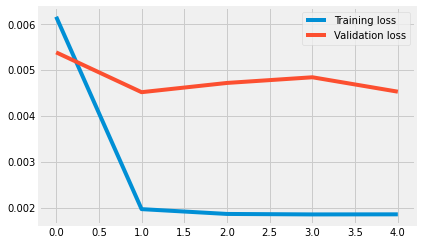

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [ ]:
#Make prediction
n_days_for_prediction=15
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 19) where n is the n_days_for_prediction


In [ ]:
prediction

In [ ]:
len(prediction)

15

### submission

In [ ]:
import re

test['Date'] = pd.to_datetime(test['Date'] , format = '%m/%d/%Y')

# using datetime to calculate time exact difference
test['End_Tenure_Date'] = test['Date'] + test["Tenor"].apply(lambda x: pd.DateOffset(years=int(''.join(x.split('Y')[:-1]))) if (x[-1]=='Y') else pd.DateOffset(months=int(''.join(x.split('M')[:-1]))))
test['Tenure'] = (test['End_Tenure_Date'] - test['Date']).dt.days

test.drop(['Tenor','End_Tenure_Date'],axis=1,inplace=True)


test.head()

,Date,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,Tenure
0,2019-10-15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,61
1,2019-10-15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,92
2,2019-10-15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,183
3,2019-10-15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,274
4,2019-10-15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,366


In [ ]:

test['new_date'] = test.groupby(['Date']).cumcount()+1
test['new_date'] = pd.to_datetime(test['Date']  , format = '%m/%d/%Y') +test['new_date'].apply(lambda x: pd.DateOffset(hours=x+2))
test['new_date']


0      2019-10-15 03:00:00
1      2019-10-15 04:00:00
2      2019-10-15 05:00:00
3      2019-10-15 06:00:00
4      2019-10-15 07:00:00
               ...        
1135   2020-01-06 17:00:00
1136   2020-01-06 18:00:00
1137   2020-01-06 19:00:00
1138   2020-01-06 20:00:00
1139   2020-01-06 21:00:00
Name: new_date, Length: 1140, dtype: datetime64[ns]

In [ ]:
test.drop('Date',axis=1,inplace=True)

In [ ]:
test_dates = test['new_date']
test.drop('new_date',axis=1,inplace=True)

In [ ]:
test['new_tenure'] = test['Tenure'].apply(lambda x: np.log1p(x))

In [ ]:
test.drop('Tenure',axis=1,inplace=True)

In [ ]:
test.head()

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,new_tenure
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.127134
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.532599
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.214936
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.616771
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.905362


In [ ]:
test_data = np.array(test)

In [ ]:
test_data.shape

(1140, 20)

In [ ]:
test_data

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        4.12713439],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        4.53259949],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        5.21493576],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        9.11964951],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        9.30191632],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        9.58952995]])

In [ ]:
testX = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 19  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my test has a shape (13623, 19, 19)
#13623 refers to the number of data points and 19 refers to the columns (multi-variables).
for i in range(n_past, len(test_data) - n_future +1):
    # print(i - n_past,i)
    testX.append(test_data[i - n_past:i,:])

testX = np.array(testX)

print('testX shape == {}.'.format(testX.shape))

In [ ]:

prediction = model.predict(testX) #shape = (n, 19) where n is the n_days_for_prediction


In [ ]:
prediction

array([[0.3303831 , 0.297053  , 0.2734894 , ..., 0.16602643, 0.16708852,
        0.16960864],
       [0.33023888, 0.29731637, 0.2730769 , ..., 0.16564587, 0.16697559,
        0.16983905],
       [0.32987103, 0.2974273 , 0.27274284, ..., 0.16540475, 0.16694893,
        0.16985394],
       ...,
       [0.33011743, 0.2968603 , 0.27354643, ..., 0.1662076 , 0.16716756,
        0.16936548],
       [0.33019724, 0.29690143, 0.2735447 , ..., 0.1661764 , 0.16714542,
        0.1694202 ],
       [0.33029494, 0.29696223, 0.2735358 , ..., 0.16612396, 0.16712172,
        0.16950041]], dtype=float32)

In [ ]:
cols= ['0.1','0.2','0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1', '1.1', '1.2', '1.3', '1.4', '1.5', '1.6', '1.7', '1.8', '1.9']

sub = pd.DataFrame(prediction,columns=cols)
sub.head()

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9
0,0.330383,0.297053,0.273489,0.248666,0.231170,0.213448,0.199272,0.183406,0.172678,0.166614,0.163763,0.160781,0.157309,0.159819,0.160624,0.164069,0.166026,0.167089,0.169609
1,0.330239,0.297316,0.273077,0.248939,0.231222,0.213647,0.198869,0.183686,0.173129,0.166731,0.163408,0.160618,0.157566,0.159988,0.160463,0.163743,0.165646,0.166976,0.169839
2,0.329871,0.297427,0.272743,0.249096,0.231036,0.213570,0.198573,0.183966,0.173431,0.166729,0.163098,0.160486,0.157852,0.160060,0.160474,0.163435,0.165405,0.166949,0.169854
3,0.329826,0.297486,0.272646,0.249163,0.231031,0.213591,0.198478,0.184047,0.173543,0.166742,0.163012,0.160453,0.157942,0.160095,0.160464,0.163342,0.165328,0.166936,0.169890
4,0.329858,0.297513,0.272626,0.249188,0.231063,0.213627,0.198453,0.184058,0.173578,0.166754,0.162997,0.160451,0.157960,0.160110,0.160447,0.163325,0.165307,0.166926,0.169921


## LSTM (Column Wise)

In [7]:
train_data = train_df.copy()

In [8]:

train_data['new_date'] = train_data.groupby(['Date']).cumcount()+1
train_data['new_date'] = pd.to_datetime(train_data['Date']  , format = '%m/%d/%Y') +train_data['new_date'].apply(lambda x: pd.DateOffset(hours=x+2))
train_data['new_date']


0       2017-01-05 03:00:00
1       2017-01-05 04:00:00
2       2017-01-05 05:00:00
3       2017-01-05 06:00:00
4       2017-01-05 07:00:00
                ...        
13637   2019-10-14 17:00:00
13638   2019-10-14 18:00:00
13639   2019-10-14 19:00:00
13640   2019-10-14 20:00:00
13641   2019-10-14 21:00:00
Name: new_date, Length: 13642, dtype: datetime64[ns]

In [52]:
test_data = test.copy()
test_data['new_date'] = test_data.groupby(['Date']).cumcount()+1
test_data['new_date'] = pd.to_datetime(test_data['Date']  , format = '%m/%d/%Y') +test_data['new_date'].apply(lambda x: pd.DateOffset(hours=x+2))
test_data['new_date']


0      2019-10-15 03:00:00
1      2019-10-15 04:00:00
2      2019-10-15 05:00:00
3      2019-10-15 06:00:00
4      2019-10-15 07:00:00
               ...        
1135   2020-01-06 17:00:00
1136   2020-01-06 18:00:00
1137   2020-01-06 19:00:00
1138   2020-01-06 20:00:00
1139   2020-01-06 21:00:00
Name: new_date, Length: 1140, dtype: datetime64[ns]

In [9]:
train_data.drop('Date',axis=1,inplace=True)
train_data.head()

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,...,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,Tenure,new_date
0,0.468214,0.419251,0.376260,0.338158,0.304372,0.274823,0.250066,0.231535,0.221404,0.220933,...,0.240437,0.254316,0.268613,0.282659,0.296172,0.309045,0.321260,0.332831,59,2017-01-05 03:00:00
1,0.458471,0.412710,0.372717,0.337489,0.306511,0.279714,0.257540,0.241007,0.231434,0.229423,...,0.242411,0.253100,0.264611,0.276244,0.287647,0.298654,0.309196,0.319254,90,2017-01-05 04:00:00
2,0.410305,0.374189,0.343045,0.316070,0.292842,0.273231,0.257346,0.245440,0.237726,0.234116,...,0.236765,0.241295,0.246945,0.253200,0.259726,0.266312,0.272831,0.279207,181,2017-01-05 05:00:00
3,0.385267,0.354580,0.328360,0.305878,0.286712,0.270643,0.257590,0.247529,0.240401,0.236030,...,0.234121,0.235658,0.238264,0.241586,0.245360,0.249397,0.253564,0.257773,273,2017-01-05 06:00:00
4,0.358986,0.333608,0.312126,0.293870,0.278408,0.265457,0.254819,0.246339,0.239855,0.235185,...,0.230384,0.229760,0.230003,0.230908,0.232303,0.234052,0.236049,0.238213,365,2017-01-05 07:00:00


In [53]:
test_data.drop('Date',axis=1,inplace=True)
test_data.head()

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,...,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,Tenure,new_date
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,61,2019-10-15 03:00:00
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,92,2019-10-15 04:00:00
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,183,2019-10-15 05:00:00
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,274,2019-10-15 06:00:00
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,366,2019-10-15 07:00:00


In [10]:
import sklearn
scaler = sklearn.preprocessing.StandardScaler()
train_data['new_tenure'] = scaler.fit_transform(train_data[['Tenure']]) 
train_data.drop('Tenure',axis=1,inplace=True)


In [54]:
test_data['new_tenure'] = scaler.transform(test_data[['Tenure']]) 

In [11]:
train_dates = train_data['new_date']
cols = ['0.1',
 '0.2',
 '0.3',
 '0.4',
 '0.5',
 '0.6',
 '0.7',
 '0.8',
 '0.9',
 '1',
 '1.1',
 '1.2',
 '1.3',
 '1.4',
 '1.5',
 '1.6',
 '1.7',
 '1.8',
 '1.9','new_tenure']
 

In [12]:
df_for_train = train_data[cols].astype(float)


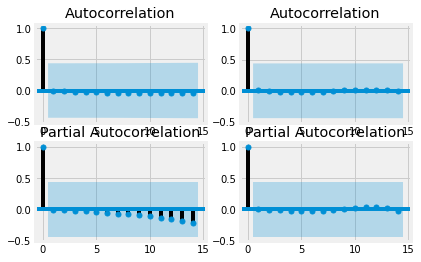

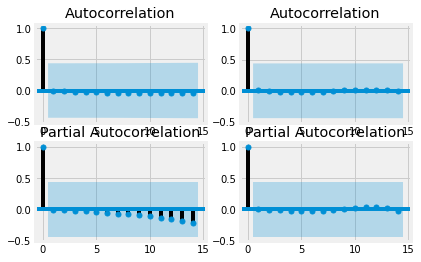

In [13]:
# Partial Autocorrelation strike prices
# plot_acf, plot_pacf
fig, ax = plt.subplots(2,2)
ax = ax.flatten()
plot_acf(df_for_train.iloc[890], ax=ax[0])
plot_acf(df_for_train.iloc[1],ax=ax[1])
plot_pacf(df_for_train.iloc[890],ax=ax[2])
plot_pacf(df_for_train.iloc[1],ax=ax[3])

In [14]:
df_for_train.describe()

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,new_tenure
count,13642.000000,13642.000000,13642.000000,13642.000000,13642.000000,13642.000000,13642.000000,13642.000000,13642.000000,13642.000000,13642.000000,13642.000000,13642.000000,13642.000000,13642.000000,13642.000000,13642.000000,13642.000000,13642.000000,1.364200e+04
mean,0.331881,0.302007,0.276614,0.254600,0.235275,0.218217,0.203196,0.190163,0.179293,0.171110,0.166120,0.163719,0.162966,0.163281,0.164325,0.165879,0.167792,0.169955,0.172287,4.922027e-17
std,0.083411,0.072003,0.062428,0.054320,0.047522,0.042011,0.037857,0.035125,0.033674,0.032751,0.031422,0.030401,0.030575,0.031971,0.034235,0.036997,0.039990,0.043047,0.046072,1.000037e+00
min,0.205536,0.189889,0.172411,0.156772,0.143881,0.133259,0.124634,0.117846,0.112773,0.109262,0.107101,0.106039,0.105816,0.105809,0.105756,0.106092,0.106715,0.107545,0.108523,-8.778937e-01
25%,0.284578,0.260605,0.239663,0.221827,0.206527,0.193467,0.181453,0.169807,0.157350,0.148284,0.144388,0.144330,0.143022,0.140938,0.139484,0.138606,0.138217,0.138277,0.138685,-8.017812e-01
50%,0.316036,0.288831,0.265497,0.245631,0.228131,0.211791,0.197402,0.183689,0.172807,0.165296,0.160233,0.157826,0.158158,0.158908,0.160004,0.160282,0.160519,0.161216,0.162009,-3.473448e-01
75%,0.351950,0.323987,0.300552,0.280610,0.262412,0.245555,0.229335,0.215078,0.203704,0.194748,0.188452,0.185057,0.183825,0.185184,0.186287,0.186490,0.187732,0.189240,0.191447,4.702427e-01
max,0.687277,0.630411,0.578715,0.531344,0.487723,0.447510,0.410605,0.377628,0.349102,0.325423,0.307731,0.296794,0.292353,0.293139,0.297555,0.305900,0.316892,0.328164,0.340378,2.741430e+00


In [15]:
X = df_for_train[['new_tenure']]
y = df_for_train.drop('new_tenure',axis=1)

In [55]:
test_data = test_data[['new_tenure']]

In [16]:
X.shape

(13642, 1)

In [17]:
f = np.array(X).reshape(X.shape[0], 1, 1,)

In [56]:
test_data = np.array(test_data).reshape(test_data.shape[0], 1, 1,)

In [18]:
in_dim = (f.shape[1], f.shape[2])
out_dim = y.shape[1]
print(in_dim,out_dim)

(1, 1) 19


In [22]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(f,y,test_size=0.2)

In [43]:
model = Sequential()
model.add(LSTM(600, input_shape=in_dim, activation="tanh",return_sequences=True))
model.add(LSTM(100, input_shape=in_dim, activation="tanh",return_sequences=True))
model.add(LSTM(50, input_shape=in_dim, activation="tanh"))
model.add(Dense(out_dim))
model.compile(loss="mae", optimizer="adam",metrics=['mae'])

In [44]:
model.fit(x_train, y_train, epochs=60, batch_size=32)

Epoch 1/60
342/342 [==============================] - 6s 6ms/step - loss: 0.0359 - mae: 0.0359
Epoch 2/60
342/342 [==============================] - 2s 6ms/step - loss: 0.0225 - mae: 0.0225
Epoch 3/60
342/342 [==============================] - 2s 6ms/step - loss: 0.0219 - mae: 0.0219
Epoch 4/60
342/342 [==============================] - 2s 6ms/step - loss: 0.0215 - mae: 0.0215
Epoch 5/60
342/342 [==============================] - 2s 6ms/step - loss: 0.0207 - mae: 0.0207
Epoch 6/60
342/342 [==============================] - 2s 6ms/step - loss: 0.0198 - mae: 0.0198
Epoch 7/60
342/342 [==============================] - 2s 6ms/step - loss: 0.0193 - mae: 0.0193
Epoch 8/60
342/342 [==============================] - 2s 6ms/step - loss: 0.0190 - mae: 0.0190
Epoch 9/60
342/342 [==============================] - 2s 6ms/step - loss: 0.0189 - mae: 0.0189
Epoch 10/60
342/342 [==============================] - 2s 6ms/step - loss: 0.0187 - mae: 0.0187
Epoch 11/60
342/342 [============================

In [45]:
ypred = model.predict(x_test)
print(ypred.shape)
for i in range(19):
    errors  = []
    error = mean_absolute_error(y_test.iloc[:,i], ypred[:,i])
    errors.append(error)
    print(f"y{i} MSE::  {error} ")
print('avg error: ',np.mean(errors))

(2729, 19)
y0 MSE::  0.016242926537416463 
y1 MSE::  0.016874444737117453 
y2 MSE::  0.01813633839420498 
y3 MSE::  0.019198960589036685 
y4 MSE::  0.020041640552779186 
y5 MSE::  0.020601324798782208 
y6 MSE::  0.021057111274970102 
y7 MSE::  0.02133866258630181 
y8 MSE::  0.021411113637902338 
y9 MSE::  0.021083237316847542 
y10 MSE::  0.020141443741352308 
y11 MSE::  0.01883774550692794 
y12 MSE::  0.01753034087026812 
y13 MSE::  0.016301034296091324 
y14 MSE::  0.015275178240660289 
y15 MSE::  0.014365765476898518 
y16 MSE::  0.013464998563252784 
y17 MSE::  0.012911695389160833 
y18 MSE::  0.012607285592063663 
avg error:  0.012607285592063663


In [46]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, ypred)

0.017759013058001812

In [47]:
ypred[:,0].shape

(2729,)

In [48]:
y_test.iloc[:,0].shape

(2729,)

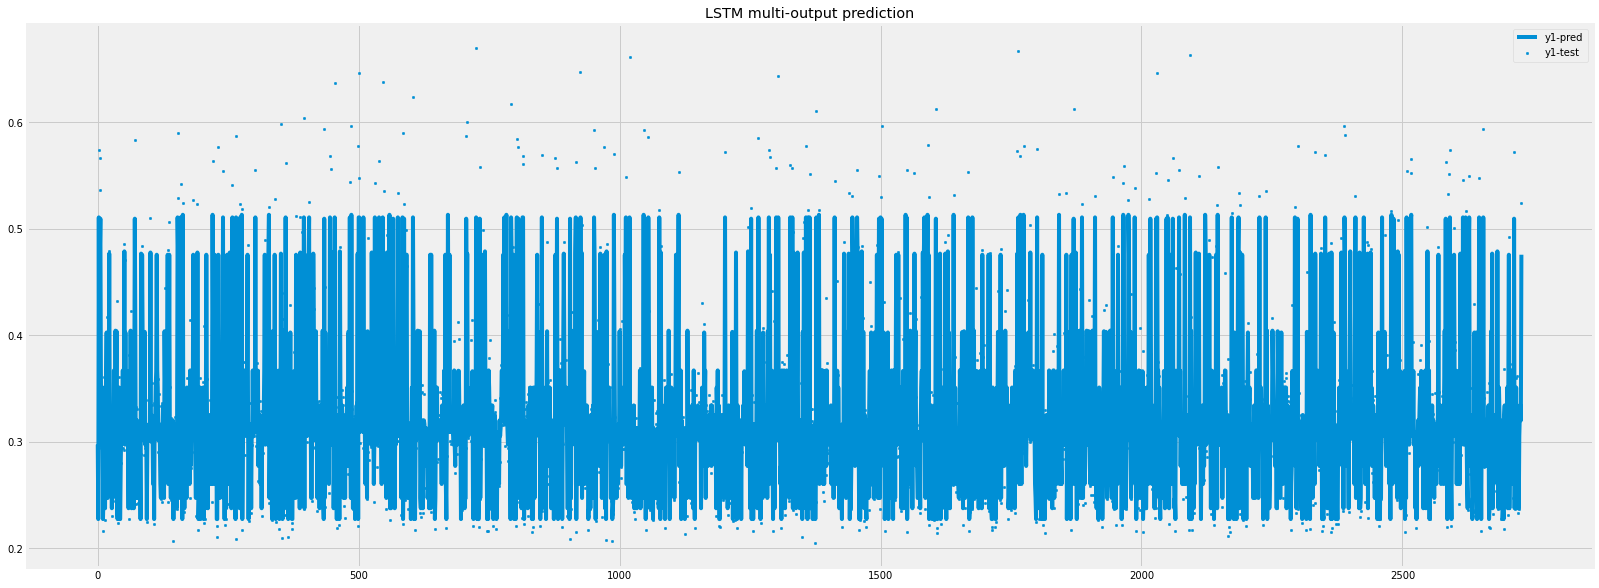

In [49]:
x_ax = range(len(x_test))

plt.figure(figsize=(25,10))
plt.title("LSTM multi-output prediction")
plt.scatter(x_ax, y_test.iloc[:,0],  s=6, label="y1-test")
plt.plot(x_ax, ypred[:,0], label="y1-pred")

# plt.scatter(x_ax, y_test.iloc[:,1],  s=6, label="y2-test")
# plt.plot(x_ax, ypred[:,1], label="y2-pred")
plt.legend()
plt.show()

### submission

In [58]:
preds = model.predict(test_data)
preds

array([[0.5106999 , 0.45339185, 0.40259176, ..., 0.24111284, 0.25167283,
        0.26202187],
       [0.47565454, 0.42364055, 0.37786824, ..., 0.2267064 , 0.23571095,
        0.24464783],
       [0.40327334, 0.36178857, 0.32646918, ..., 0.19721784, 0.20302999,
        0.20876029],
       ...,
       [0.24738127, 0.22677436, 0.21025372, ..., 0.1218535 , 0.12231665,
        0.122476  ],
       [0.23775336, 0.21767588, 0.20184779, ..., 0.12011395, 0.12067325,
        0.12097796],
       [0.2275937 , 0.20779335, 0.19289476, ..., 0.11925843, 0.12001997,
        0.12032156]], dtype=float32)

In [63]:
cols = ['0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1','1.1','1.2','1.3','1.4','1.5','1.6','1.7','1.8','1.9']
sol = pd.DataFrame(data=preds,columns=cols)
sol

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9
0,0.510700,0.453392,0.402592,0.352252,0.310299,0.269757,0.233361,0.202493,0.178728,0.164237,0.162606,0.171345,0.184807,0.199406,0.212466,0.226013,0.241113,0.251673,0.262022
1,0.475655,0.423641,0.377868,0.332212,0.294821,0.258625,0.225973,0.198964,0.178518,0.165724,0.163622,0.169884,0.180231,0.192545,0.202832,0.214140,0.226706,0.235711,0.244648
2,0.403273,0.361789,0.326469,0.291243,0.263023,0.235619,0.210838,0.192109,0.178017,0.168818,0.165387,0.167040,0.171253,0.178080,0.183194,0.189563,0.197218,0.203030,0.208760
3,0.366843,0.330622,0.300755,0.271329,0.247740,0.224787,0.204141,0.189725,0.178467,0.170916,0.166643,0.166286,0.167486,0.170903,0.173678,0.177346,0.182613,0.186764,0.190568
4,0.350956,0.317380,0.290114,0.263421,0.242114,0.221299,0.202620,0.190015,0.179875,0.172716,0.168075,0.166892,0.166609,0.168274,0.169898,0.172335,0.176307,0.179651,0.182386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135,0.277425,0.253628,0.235447,0.217555,0.203941,0.189807,0.177765,0.169056,0.160416,0.154471,0.147944,0.143965,0.140710,0.138057,0.136211,0.134431,0.133904,0.133868,0.133263
1136,0.260510,0.238707,0.221440,0.204670,0.191773,0.178128,0.166652,0.158380,0.150135,0.144087,0.138214,0.134462,0.131947,0.129615,0.128161,0.126854,0.126074,0.126383,0.126207
1137,0.247381,0.226774,0.210254,0.194500,0.182546,0.169589,0.158484,0.150759,0.143063,0.137115,0.131983,0.128604,0.126699,0.124611,0.123542,0.122646,0.121854,0.122317,0.122476
1138,0.237753,0.217676,0.201848,0.186848,0.175718,0.163566,0.152819,0.145576,0.138390,0.132883,0.128412,0.125475,0.123909,0.122103,0.121406,0.120660,0.120114,0.120673,0.120978


In [ ]:
sol.to_csv('solution.csv',index=False)

# References
[Scholes model](https://www.investopedia.com/terms/b/blackscholes.asp) :investopedia

[Multi Ouput Regression](https://machinelearningmastery.com/multi-output-regression-models-with-python/) :machinelearningmastery

[Visualisations](https://plotly.com/python/financial-charts/) :PLotly

[Cointegration Test](https://blog.quantinsti.com/johansen-test-cointegration-building-stationary-portfolio/) :Quantinsti

[MultiOutregression with RNN](https://www.datatechnotes.com/2019/12/multi-output-regression-example-with_24.html) :datatechnotes